The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# Gradiente Descendente Estocástico
:label:`sec_sgd`

Nesta seção, apresentaremos os princípios básicos da gradiente descendente estocástico.


In [1]:
%matplotlib inline
import math
import torch
from d2l import torch as d2l

## Atualizações de gradiente estocástico

No aprendizado profundo, a função objetivo é geralmente a média das funções de perda para cada exemplo no conjunto de dados de treinamento. Assumimos que $f_i(\mathbf{x})$ é a função de perda do conjunto de dados de treinamento com $n$ exemplos, um índice de $i$ e um vetor de parâmetro de $\mathbf{x}$, então temos o função objetiva

$$f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\mathbf{x}).$$

O gradiente da função objetivo em $\mathbf{x}$ é calculado como

$$\nabla f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}).$$

Se o gradiente descendente for usado, o custo de computação para cada iteração de variável independente é $\mathcal{O}(n)$, que cresce linearmente com $n$. Portanto, quando o conjunto de dados de treinamento do modelo é grande, o custo da descida do gradiente para cada iteração será muito alto.

A descida gradiente estocástica (SGD) reduz o custo computacional a cada iteração. A cada iteração de descida do gradiente estocástico, amostramos uniformemente um índice $i\in\{1,\ldots, n\}$ para exemplos de dados aleatoriamente e calculamos o gradiente $\nabla f_i(\mathbf{x})$ para atualizar $\mathbf{x}$:

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f_i(\mathbf{x}).$$

Aqui, $\eta$ é a taxa de aprendizado. Podemos ver que o custo de computação para cada iteração cai de $\mathcal{O}(n)$ da descida do gradiente para a constante $\mathcal{O}(1)$. Devemos mencionar que o gradiente estocástico $\nabla f_i(\mathbf{x})$ é a estimativa imparcial do gradiente $\nabla f(\mathbf{x})$.

$$\mathbb{E}_i \nabla f_i(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}) = \nabla f(\mathbf{x}).$$

Isso significa que, em média, o gradiente estocástico é uma boa estimativa do gradiente.

Agora, vamos compará-lo com a descida do gradiente adicionando ruído aleatório com uma média de 0 e uma variância de 1 ao gradiente para simular um SGD.


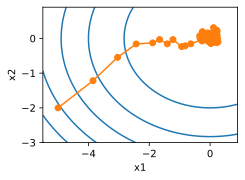

In [2]:
f = lambda x1, x2: x1 ** 2 + 2 * x2 ** 2  # Objective
gradf = lambda x1, x2: (2 * x1, 4 * x2)  # Gradient

def sgd(x1, x2, s1, s2):
    global lr  # Learning rate scheduler
    (g1, g2) = gradf(x1, x2)
    # Simulate noisy gradient
    g1 += torch.normal(0.0, 1, (1,))
    g2 += torch.normal(0.0, 1, (1,))
    eta_t = eta * lr()  # Learning rate at time t
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)  # Update variables

eta = 0.1
lr = (lambda: 1)  # Constant learning rate
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50))

Como podemos ver, a trajetória das variáveis ​​no SGD é muito mais ruidosa do que a que observamos na descida do gradiente na seção anterior. Isso se deve à natureza estocástica do gradiente. Ou seja, mesmo quando chegamos perto do mínimo, ainda estamos sujeitos à incerteza injetada pelo gradiente instantâneo via $\eta \nabla f_i(\mathbf{x})$. Mesmo após 50 passos, a qualidade ainda não é tão boa. Pior ainda, não melhorará após etapas adicionais (encorajamos o leitor a experimentar um número maior de etapas para confirmar isso por conta própria). Isso nos deixa com a única alternativa --- alterar a taxa de aprendizagem $\eta$. No entanto, se escolhermos isso muito pequeno, não faremos nenhum progresso significativo inicialmente. Por outro lado, se o escolhermos muito grande, não obteremos uma boa solução, como visto acima. A única maneira de resolver esses objetivos conflitantes é reduzir a taxa de aprendizado *dinamicamente* à medida que a otimização avança.

Esta também é a razão para adicionar uma função de taxa de aprendizagem `lr` na função de passo` sgd`. No exemplo acima, qualquer funcionalidade para o agendamento da taxa de aprendizagem permanece latente, pois definimos a função `lr` associada como constante, ou seja,` lr = (lambda: 1) `.

## Taxa de aprendizagem dinâmica

Substituir $\eta$ por uma taxa de aprendizado dependente do tempo $\eta(t)$ aumenta a complexidade de controlar a convergência de um algoritmo de otimização. Em particular, é preciso descobrir com que rapidez $\eta$ deve decair. Se for muito rápido, pararemos de otimizar prematuramente. Se diminuirmos muito lentamente, perderemos muito tempo com a otimização. Existem algumas estratégias básicas que são usadas no ajuste de $\eta$ ao longo do tempo (discutiremos estratégias mais avançadas em um capítulo posterior):

$$
\begin{aligned}
    \eta(t) & = \eta_i \text{ if } t_i \leq t \leq t_{i+1}  && \mathrm{piecewise~constant} \\
    \eta(t) & = \eta_0 \cdot e^{-\lambda t} && \mathrm{exponential} \\
    \eta(t) & = \eta_0 \cdot (\beta t + 1)^{-\alpha} && \mathrm{polynomial}
\end{aligned}
$$

No primeiro cenário, diminuímos a taxa de aprendizado, por exemplo, sempre que o progresso na otimização para. Esta é uma estratégia comum para treinar redes profundas. Alternativamente, poderíamos diminuí-lo de forma muito mais agressiva por uma redução exponencial. Infelizmente, isso leva a uma parada prematura antes que o algoritmo tenha convergido. Uma escolha popular é o decaimento polinomial com $\alpha = 0.5$. No caso da otimização convexa, há uma série de provas que mostram que essa taxa é bem comportada. Vamos ver como isso se parece na prática.


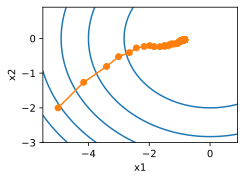

In [3]:
def exponential():
    global ctr
    ctr += 1
    return math.exp(-0.1 * ctr)

ctr = 1
lr = exponential  # Set up learning rate
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=1000))

Como esperado, a variância nos parâmetros é reduzida significativamente. No entanto, isso ocorre às custas de não convergir para a solução ótima $\mathbf{x} = (0, 0)$. Mesmo depois de 1000 passos, ainda estamos muito longe da solução ideal. Na verdade, o algoritmo não consegue convergir. Por outro lado, se usarmos um decaimento polinomial onde a taxa de aprendizagem decai com a raiz quadrada inversa do número de passos, a convergência é boa.


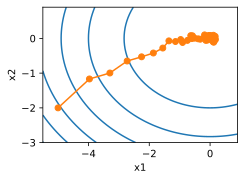

In [4]:
def polynomial():
    global ctr
    ctr += 1
    return (1 + 0.1 * ctr)**(-0.5)

ctr = 1
lr = polynomial  # Set up learning rate
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50))

Existem muitas outras opções de como definir a taxa de aprendizagem. Por exemplo, poderíamos começar com uma taxa pequena, aumentar rapidamente e diminuí-la novamente, embora mais lentamente. Poderíamos até alternar entre taxas de aprendizagem menores e maiores. Existe uma grande variedade de tais horários. Por enquanto, vamos nos concentrar em tabelas de taxas de aprendizagem para as quais uma análise teórica abrangente é possível, ou seja, em taxas de aprendizagem em um cenário convexo. Para problemas não-convexos gerais é muito difícil obter garantias de convergência significativas, uma vez que, em geral, minimizar problemas não-convexos não lineares é NP difícil. Para uma pesquisa, consulte, por exemplo, as excelentes [notas de aula](https://www.stat.cmu.edu/~ryantibs/convexopt-F15/lectures/26-nonconvex.pdf) de Tibshirani 2015.

## Análise de convergência para objetivos convexos

O que segue é opcional e serve principalmente para transmitir mais intuição sobre o problema. Nos limitamos a uma das provas mais simples, conforme descrito por :cite:`Nesterov.Vial.2000`. Existem técnicas de prova significativamente mais avançadas, por exemplo, sempre que a função objetiva é particularmente bem comportada. :cite:`Hazan.Rakhlin.Bartlett.2008` mostra que para funções fortemente convexas, ou seja, para funções que podem ser limitadas de baixo por $\mathbf{x}^\top \mathbf{Q} \mathbf{x}$ , é possível minimizá-los em um pequeno número de etapas enquanto diminui a taxa de aprendizagem como $\eta(t) = \eta_0/(\beta t + 1)$. Infelizmente, esse caso nunca ocorre realmente no aprendizado profundo e ficamos com uma taxa de diminuição muito mais lenta na prática.

Considere o caso onde
$$\mathbf{w}_{t+1} = \mathbf{w}_{t} - \eta_t \partial_\mathbf{w} l(\mathbf{x}_t, \mathbf{w}).$$

Em particular, assuma que $\mathbf{x}_t$ é retirado de alguma distribuição $P(\mathbf{x})$ e que $l(\mathbf{x}, \mathbf{w})$ é uma função convexa em $\mathbf{w}$ para todos os $\mathbf{x}$. Última denotada por

$$R(\mathbf{w}) = E_{\mathbf{x} \sim P}[l(\mathbf{x}, \mathbf{w})]$$

o risco esperado e por $R^*$ seu mínimo em relação a $\mathbf{w}$. Por último, seja $\mathbf{w}^*$ o minimizador (assumimos que ele existe dentro do domínio que $\mathbf{w}$ está definido). Neste caso, podemos rastrear a distância entre o parâmetro atual $\mathbf{w}_t$ e o minimizador de risco $\mathbf{w}^*$ e ver se melhora com o tempo:

$$\begin{aligned}
    \|\mathbf{w}_{t+1} - \mathbf{w}^*\|^2 & = \|\mathbf{w}_{t} - \eta_t \partial_\mathbf{w} l(\mathbf{x}_t, \mathbf{w}) - \mathbf{w}^*\|^2 \\
    & = \|\mathbf{w}_{t} - \mathbf{w}^*\|^2 + \eta_t^2 \|\partial_\mathbf{w} l(\mathbf{x}_t, \mathbf{w})\|^2 - 2 \eta_t
    \left\langle \mathbf{w}_t - \mathbf{w}^*, \partial_\mathbf{w} l(\mathbf{x}_t, \mathbf{w})\right\rangle.
   \end{aligned}
$$

O gradiente $\partial_\mathbf{w} l(\mathbf{x}_t, \mathbf{w})$ pode ser limitado de cima por alguma constante de Lipschitz $L$, portanto, temos que

$$\eta_t^2 \|\partial_\mathbf{w} l(\mathbf{x}_t, \mathbf{w})\|^2 \leq \eta_t^2 L^2.$$

Estamos principalmente interessados em como a distância entre $\mathbf{w}_t$ e $\mathbf{w}^*$ muda *na expectativa*. Na verdade, para qualquer sequência específica de passos, a distância pode muito bem aumentar, dependendo de qualquer $\mathbf{x}_t$ que encontrarmos. Portanto, precisamos limitar o produto interno. Por convexidade temos que

$$
l(\mathbf{x}_t, \mathbf{w}^*) \geq l(\mathbf{x}_t, \mathbf{w}_t) + \left\langle \mathbf{w}^* - \mathbf{w}_t, \partial_{\mathbf{w}} l(\mathbf{x}_t, \mathbf{w}_t) \right\rangle.
$$

Usando ambas as desigualdades e conectando-as ao acima, obtemos um limite para a distância entre os parâmetros no tempo $t+1$ da seguinte forma:

$$\|\mathbf{w}_{t} - \mathbf{w}^*\|^2 - \|\mathbf{w}_{t+1} - \mathbf{w}^*\|^2 \geq 2 \eta_t (l(\mathbf{x}_t, \mathbf{w}_t) - l(\mathbf{x}_t, \mathbf{w}^*)) - \eta_t^2 L^2.$$

Isso significa que progredimos enquanto a diferença esperada entre a perda atual e a perda ótima supera $\eta_t L^2$. Como o primeiro tende a convergir para $0$, segue-se que a taxa de aprendizado $\eta_t$ também precisa desaparecer.

Em seguida, consideramos as expectativas sobre essa expressão. Isso produz

$$E_{\mathbf{w}_t}\left[\|\mathbf{w}_{t} - \mathbf{w}^*\|^2\right] - E_{\mathbf{w}_{t+1}\mid \mathbf{w}_t}\left[\|\mathbf{w}_{t+1} - \mathbf{w}^*\|^2\right] \geq 2 \eta_t [E[R[\mathbf{w}_t]] - R^*] -  \eta_t^2 L^2.$$

A última etapa envolve a soma das desigualdades para $t \in \{t, \ldots, T\}$. Uma vez que a soma dos telescópios e diminuindo o termo inferior, obtemos

$$\|\mathbf{w}_{0} - \mathbf{w}^*\|^2 \geq 2 \sum_{t=1}^T \eta_t [E[R[\mathbf{w}_t]] - R^*] - L^2 \sum_{t=1}^T \eta_t^2.$$

Observe que exploramos que $\mathbf{w}_0$ é dado e, portanto, a expectativa pode ser descartada. Última definição

$$\bar{\mathbf{w}} := \frac{\sum_{t=1}^T \eta_t \mathbf{w}_t}{\sum_{t=1}^T \eta_t}.$$

Então, por convexidade, segue-se que

$$\sum_t \eta_t E[R[\mathbf{w}_t]] \geq \sum \eta_t \cdot \left[E[\bar{\mathbf{w}}]\right].$$

Conectar isso à desigualdade acima produz o limite

$$
\left[E[\bar{\mathbf{w}}]\right] - R^* \leq \frac{r^2 + L^2 \sum_{t=1}^T \eta_t^2}{2 \sum_{t=1}^T \eta_t}.
$$

Aqui $r^2 := \|\mathbf{w}_0 - \mathbf{w}^*\|^2$ é um limite na distância entre a escolha inicial dos parâmetros e o resultado final. Em suma, a velocidade de convergência depende de quão rapidamente a função de perda muda por meio da constante de Lipschitz $L$ e quão longe da otimização o valor inicial está $r$. Observe que o limite é em termos de $\bar{\mathbf{w}}$ em vez de $\mathbf{w}_T$. Este é o caso, pois $\bar{\mathbf{w}}$ é uma versão suavizada do caminho de otimização. Agora vamos analisar algumas opções para $\eta_t$.

* **Horizonte de tempo conhecido**. Sempre que $r, L$ e $T$ são conhecidos, podemos escolher $$\eta = r/L \sqrt{T}$. Isso resulta no limite superior $r L (1 + 1/T)/2\sqrt{T} < rL/\sqrt{T}$. Ou seja, convergimos com a taxa $\mathcal{O}(1/\sqrt{T})$ para a solução ótima.
* **Horizonte de tempo desconhecido**. Sempre que quisermos ter uma boa solução para *a qualquer* momento $T$, podemos escolher $\eta = \mathcal{O}(1/\sqrt{T})$. Isso nos custa um fator logarítmico extra e leva a um limite superior da forma $\mathcal{O}(\log T / \sqrt{T})$.

Observe que para perdas fortemente convexas $l(\mathbf{x}, \mathbf{w}') \geq l(\mathbf{x}, \mathbf{w}) + \langle \mathbf{w}'-\mathbf{w}, \partial_\mathbf{w} l(\mathbf{x}, \mathbf{w}) \rangle + \frac{\lambda}{2} \|\mathbf{w}-\mathbf{w}'\|^2$  podemos projetar agendas de otimização convergentes ainda mais rapidamente. Na verdade, um declínio exponencial em $\eta$ leva a um limite da forma $\mathcal{O}(\log T / T)$.

## Gradientes estocásticos e amostras finitas

Até agora, fomos um pouco rápidos e soltos quando se trata de falar sobre a descida gradiente estocástica. Postulamos que desenhamos instâncias $x_i$, normalmente com rótulos $y_i$ de alguma distribuição $p(x, y)$ e que usamos isso para atualizar os pesos $w$ de alguma maneira. Em particular, para um tamanho de amostra finito, simplesmente argumentamos que a distribuição discreta $p(x, y) = \frac{1}{n} \sum_{i=1}^n \delta_{x_i}(x) \delta_{y_i}(y)$ nos permite realizar SGD sobre ele.

No entanto, não foi exatamente isso que fizemos. Nos exemplos de brinquedos na seção atual, simplesmente adicionamos ruído a um gradiente não estocástico, ou seja, fingimos ter pares $(x_i, y_i)$. Acontece que isso se justifica aqui (veja os exercícios para uma discussão detalhada). Mais preocupante é que em todas as discussões anteriores claramente não fizemos isso. Em vez disso, iteramos em todas as instâncias exatamente uma vez. Para ver por que isso é preferível, considere o inverso, ou seja, estamos amostrando $n$ observações da distribuição discreta com substituição. A probabilidade de escolher um elemento $i$ aleatoriamente é $N^{-1}$. Portanto, escolher pelo menos uma vez é

$$P(\mathrm{choose~} i) = 1 - P(\mathrm{omit~} i) = 1 - (1-N^{-1})^N \approx 1-e^{-1} \approx 0.63.$$

Um raciocínio semelhante mostra que a probabilidade de escolher uma amostra exatamente uma vez é dada por ${N \choose 1} N^{-1} (1-N^{-1})^{N-1} = \frac{N-1}{N} (1-N^{-1})^{N} \approx e^{-1} \approx 0.37$. Isso leva a um aumento da variância e diminuição da eficiência dos dados em relação à amostragem sem reposição. Portanto, na prática, fazemos o último (e esta é a escolha padrão em todo este livro). Por último, observe que passagens repetidas pelo conjunto de dados percorrem-no em uma ordem aleatória *diferente*.


## Sumário

* Para problemas convexos, podemos provar que, para uma ampla escolha de taxas de aprendizado, a Descida de Gradiente Estocástico convergirá para a solução ótima.
* Geralmente, esse não é o caso para aprendizagem profunda. No entanto, a análise de problemas convexos nos dá uma visão útil sobre como abordar a otimização, nomeadamente para reduzir a taxa de aprendizagem progressivamente, embora não muito rapidamente.
* Os problemas ocorrem quando a taxa de aprendizagem é muito pequena ou muito grande. Na prática, uma taxa de aprendizado adequada geralmente é encontrada somente após vários experimentos.
* Quando há mais exemplos no conjunto de dados de treinamento, custa mais calcular cada iteração para a descida do gradiente, portanto, SGD é preferível nesses casos.
* As garantias de otimização para SGD em geral não estão disponíveis em casos não convexos, pois o número de mínimos locais que requerem verificação pode ser exponencial.


## Exercícios

1. Experimente diferentes programações de taxa de aprendizagem para SGD e com diferentes números de iterações. Em particular, plote a distância da solução ótima $(0, 0)$ como uma função do número de iterações.
1. Prove que para a função $f(x_1, x_2) = x_1^2 + 2 x_2^2$ adicionar ruído normal ao gradiente é equivalente a minimizar uma função de perda $l(\mathbf{x}, \mathbf{w}) = (x_1 - w_1)^2 + 2 (x_2 - w_2)^2$ onde $x$  é extraído de uma distribuição normal.
    * Derive a média e a variância da distribuição de $\mathbf{x}$.
    * Mostre que esta propriedade é geralmente válida para funções objetivo $f(\mathbf{x}) = \frac{1}{2} (\mathbf{x} - \mathbf{\mu})^\top Q (\mathbf{x} - \mathbf{\mu})$ para $Q \succeq 0$.
1. Compare a convergência de SGD quando você faz a amostra de $\{(x_1, y_1), \ldots, (x_m, y_m)\}$ com substituição e quando você faz a amostra sem substituição.
1. Como você mudaria o solucionador SGD se algum gradiente (ou melhor, alguma coordenada associada a ele) fosse consistentemente maior do que todos os outros gradientes?
1. Suponha que $f(x) = x^2 (1 + \sin x)$. Quantos mínimos locais $f$ tem? Você pode alterar $f$ de forma que, para minimizá-lo, seja necessário avaliar todos os mínimos locais?


[Discussão](https://discuss.d2l.ai/t/497)


<!--stackedit_data:
eyJoaXN0b3J5IjpbNDY3NDY4MTIwLDIwNDU5ODAwOTYsMTAyMj
MyMDgwM119
-->
